# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

### Initialization ###
Starting Spark session:

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
spark

In [3]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [4]:
import urllib.request

In [5]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7fbbc355f4d0>)

Create a first RDD

In [6]:
lines = sc.textFile("apache_logs")

Perform a *transformation*

In [7]:
lineLengths = lines.map(lambda s: len(s))

Perform an *action*

In [8]:
totalLength = lineLengths.reduce(lambda a, b: a + b)

Finally evaluate (laziness!)

In [9]:
totalLength

2360789

### Custom functions

In [10]:
def myFunc(s):
    words = s.split(" ")
    return len(words)

In [11]:
wordCounts = lines.map(myFunc)

In [12]:
wordCounts.max()

43

In [13]:
wordCounts.histogram([0,10,20,30,40,50])

([0, 10, 20, 30, 40, 50], [0, 4901, 4719, 378, 2])

In [14]:
wordCounts.count()

10000

### Map-Reduce pattern

Let's look closer at our log file format:

```
99.158.0.150 - - [18/May/2015:04:05:37 +0000] "GET /images/jordan-80.png HTTP/1.1" 200 6146 "http://www.semicomplete.com/articles/dynamic-dns-with-dhcp/" "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/32.0.1700.102 Chrome/32.0.1700.102 Safari/537.36"
```

Count lines containing "Chrome":

In [15]:
chromeLines = lines.map(lambda s: (1 if "Chrome" in s else 0))

In [16]:
counts = chromeLines.reduce(lambda a, b: a + b)

In [17]:
counts

3172

### Key-Value Pairs

Count IP addresses

In [18]:
regex = '([(\d\.)]+)'

In [19]:
import re

In [20]:
ip = re.match(regex, '99.158.0.150 - - ').group(0)

In [21]:
print(ip)

99.158.0.150


In [22]:
ips = lines.map(lambda s: (re.match(regex, s).group(0) ,1))

In [23]:
ipCounts = ips.reduceByKey(lambda a, b: a + b)

Get results

In [213]:
ipCounts.take(10)

[('83.149.9.216', 23),
 ('24.236.252.67', 1),
 ('93.114.45.13', 6),
 ('66.249.73.135', 482),
 ('50.16.19.13', 113),
 ('66.249.73.185', 56),
 ('50.150.204.184', 1),
 ('207.241.237.225', 13),
 ('200.49.190.101', 3),
 ('200.49.190.100', 1)]

In [25]:
ipCounts.take(20)

[('83.149.9.216', 23),
 ('24.236.252.67', 1),
 ('93.114.45.13', 6),
 ('66.249.73.135', 482),
 ('50.16.19.13', 113),
 ('66.249.73.185', 56),
 ('50.150.204.184', 1),
 ('207.241.237.225', 13),
 ('200.49.190.101', 3),
 ('200.49.190.100', 1),
 ('67.214.178.190', 2),
 ('207.241.237.227', 17),
 ('207.241.237.228', 16),
 ('207.241.237.101', 17),
 ('209.85.238.199', 102),
 ('218.30.103.62', 16),
 ('74.125.40.20', 2),
 ('71.212.224.97', 5),
 ('108.174.55.234', 23),
 ('198.46.149.143', 82)]

Sort by values (ascending):

In [26]:
ipCounts.takeOrdered(10, lambda pair: pair[1])

[('24.236.252.67', 1),
 ('50.150.204.184', 1),
 ('200.49.190.100', 1),
 ('24.233.162.179', 1),
 ('220.181.108.153', 1),
 ('112.110.247.238', 1),
 ('66.168.50.129', 1),
 ('180.76.5.27', 1),
 ('93.164.60.142', 1),
 ('94.175.135.116', 1)]

Sort by values (descending):

In [27]:
topIPs = ipCounts.takeOrdered(10, lambda pair: -pair[1])
topIPs

[('66.249.73.135', 482),
 ('46.105.14.53', 364),
 ('130.237.218.86', 357),
 ('75.97.9.59', 273),
 ('50.16.19.13', 113),
 ('209.85.238.199', 102),
 ('68.180.224.225', 99),
 ('100.43.83.137', 84),
 ('208.115.111.72', 83),
 ('198.46.149.143', 82)]

### Plotting

In [28]:
import pandas as pd

In [29]:
df = pd.DataFrame(topIPs, columns=['IP', 'Count'])
df

,IP,Count
0,66.249.73.135,482
1,46.105.14.53,364
2,130.237.218.86,357
3,75.97.9.59,273
4,50.16.19.13,113
5,209.85.238.199,102
6,68.180.224.225,99
7,100.43.83.137,84
8,208.115.111.72,83
9,198.46.149.143,82


In [30]:
import matplotlib.pyplot as plt

<Axes: ylabel='IP'>

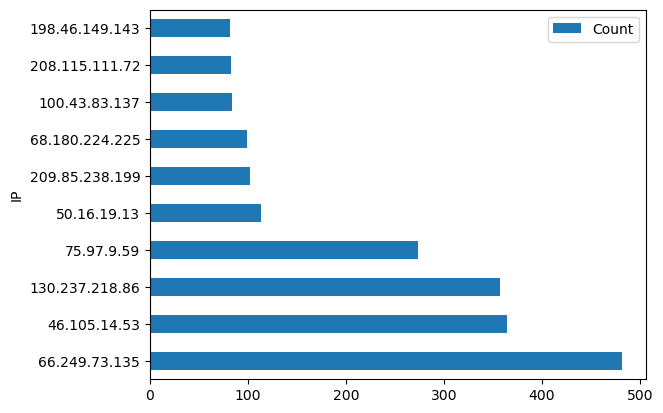

In [31]:
df.plot.barh(x = 'IP')

### Closures and accumulators

Local variables are not passed to closures or functions, they remain local!

In [32]:
counter = 0

# Wrong: Don't do this!!
def increment_counter(x):
    global counter
    counter += x

wordCounts.foreach(increment_counter)

print("Counter value: ", counter)

Counter value:  0


Use *accumulators* instead

In [33]:
accum = sc.accumulator(0)
accum

Accumulator<id=0, value=0>

In [34]:
# Correct way is to use accumulators
def increment_counter(x):
    accum.add(x)

wordCounts.foreach(increment_counter)

print("Counter value: ", accum)

Counter value:  197956


# Zadanie 1

Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

In [36]:
regex = 'http:\/\/\w*\.\w*\.\w*|http:\/\/\w*\.\w*'

# search
referers = lines.flatMap(lambda s: [(match, 1) for match in re.findall(regex, s)])
referers = referers.reduceByKey(lambda a, b: a + b)

# filter
referers = referers.map(lambda x: (x[0].replace('http://', ''), x[1])).map(lambda x: (x[0].replace('www.', ''), x[1]))
referers = referers.filter(lambda line: 'semicomplete.com' not in line)

top_referers = referers.takeOrdered(10, lambda pair: -pair[1])
top_referers

[('google.com', 784),
 ('feedparser.org', 364),
 ('archive.org', 171),
 ('search.msn.com', 118),
 ('FeedBurner.com', 108),
 ('help.yahoo.com', 106),
 ('baidu.com', 87),
 ('yandex.com', 86),
 ('bing.com', 64),
 ('opscode.com', 61)]

Text(0.5, 1.0, 'Top referers excluding semicomplete.com')

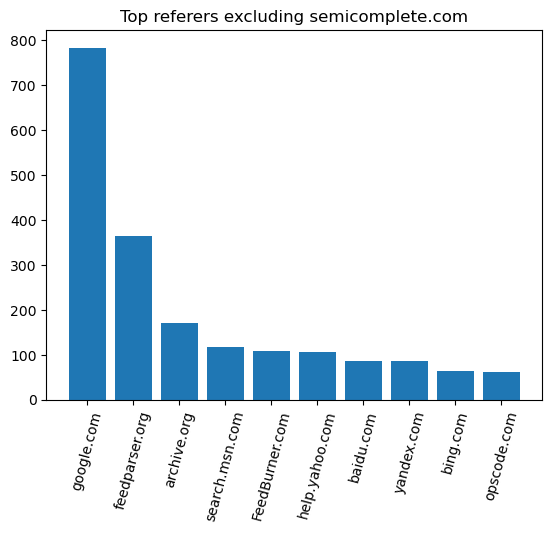

In [39]:
names = [x[0] for x in top_referers]
number = [x[1] for x in top_referers]
plt.bar(names, number)
plt.xticks(rotation=75)
plt.title('Top referers excluding semicomplete.com')

# Zadanie 2
Narysować wykres rankingu pobieranych plików graficznych.

In [62]:
index = images_counter.map(lambda x: x[0].rindex('/'))
index

PythonRDD[57] at RDD at PythonRDD.scala:53

In [71]:
regex = '(([^\s]+)(jpg|jpeg|png|svg|gif))'

# search
images = lines.flatMap(lambda s: [(match[0], 1) for match in re.findall(regex, s)])
images_counter = referers.reduceByKey(lambda a, b: a + b)

# filter
images_cut = images_counter.map(lambda x: (x[0][x[0].rindex('/')+1:], x[1]))

# display
top_images = images_cut.takeOrdered(10, lambda pair: -pair[1])
top_images

[('jordan-80.png', 533),
 ('banner.png', 516),
 ('ahhh___rage_face_by_samusmmx-d5g5zap.png', 128),
 ('googledotcom.png', 101),
 ('kibana-logstash-downloads.png', 33),
 ('logstash.png', 33),
 ('office-space-printer-beat-down-gif.gif', 32),
 ('nagios-sms1.png', 26),
 ('apache-negative-duration.png', 25),
 ('blank.gif', 25)]

Text(0.5, 1.0, 'Top images')

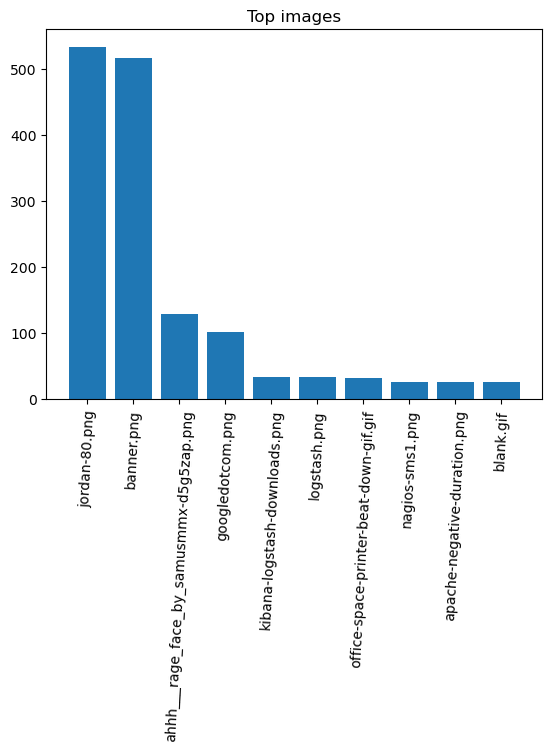

In [76]:
names = [x[0] for x in top_images]
number = [x[1] for x in top_images]
plt.bar(names, number)
plt.xticks(rotation=87)
plt.title('Top images')

# Zadanie 3

Narysować średni dobowy wykres liczby wywołań (request) na minutę w zależności od czasu.

In [153]:
regex = r'\b\d\d:\d\d'

# search
request = lines.flatMap(lambda s: [(match, 1) for match in re.findall(regex, s)])
request_counter = request.reduceByKey(lambda a, b: a + b)

# display
sorted_time = request_counter.sortBy(lambda x: x[0]).collect()
sorted_time

[('00:05', 361),
 ('01:05', 360),
 ('02:05', 365),
 ('03:05', 354),
 ('04:05', 355),
 ('05:05', 371),
 ('06:05', 366),
 ('07:05', 357),
 ('08:05', 345),
 ('09:05', 364),
 ('10:05', 443),
 ('11:05', 459),
 ('12:05', 462),
 ('13:05', 475),
 ('14:05', 498),
 ('14:41', 16),
 ('15:05', 496),
 ('16:05', 473),
 ('17:05', 484),
 ('18:05', 478),
 ('19:05', 493),
 ('20:05', 486),
 ('21:05', 453),
 ('22:05', 346),
 ('23:05', 356)]

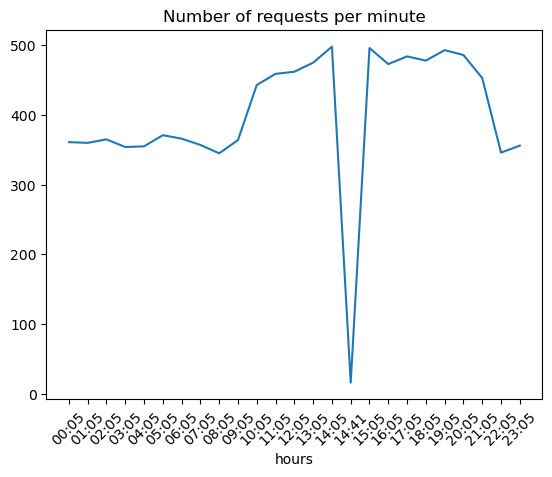

In [154]:
names = [x[0] for x in sorted_time]
number = [x[1] for x in sorted_time]

plt.plot(names, number)
plt.xlabel('hours')
plt.title('Number of requests per minute')
plt.xticks(rotation=45)
plt.show()

# Zadanie 4

Narysować wykres (pie chart) popularności systemów operacyjnych klienta

In [230]:
regex = r'Windows|Linux|Mac OS|Android'

# search
system = lines.flatMap(lambda s: [(match, 1) for match in re.findall(regex, s)])
system_counter = request.reduceByKey(lambda a, b: a + b)

# display
systems = request_counter.collect()
systems

[('Linux', 2247), ('Android', 188), ('Mac OS', 1823), ('Windows', 3456)]

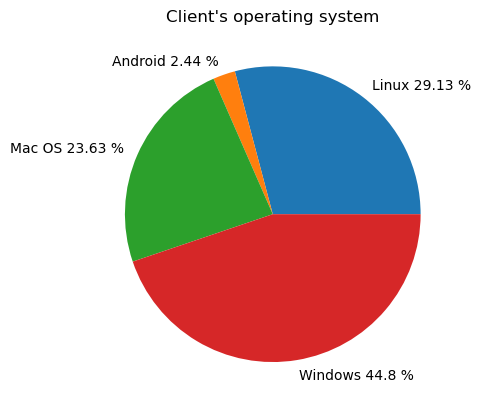

In [235]:
# plot
values = [s[1] for s in systems] 
val_percent = [str(round((v/sum(values))*100, 2)) for v in values]

names = [s[0] for s in systems]
names = list(map(lambda a, b: f"{a} {b} %", names, val_percent))

plt.pie(values, labels = names)
plt.title('Client\'s operating system')
plt.show()

# Zadanie 5

Oszacować jaki procent ruchu generują boty. Porównać co najmniej 2 sposoby oszacowania.

### 1 method - searching bot's name in user-agent

In [258]:
regex = r'Googlebot|Bingbot|Baidu|Slurp|Sogou|MJ12bot'

# search
bots = lines.flatMap(lambda s: [(match, 1) for match in re.findall(regex, s)])
bots_counter = request.reduceByKey(lambda a, b: a + b)

# display
bots = bots_counter.takeOrdered(10, lambda pair: -pair[1])
bots

[('Googlebot', 543),
 ('Slurp', 106),
 ('Baidu', 84),
 ('MJ12bot', 39),
 ('Sogou', 18)]

In [255]:
logs_nb = len(lines.collect())
bots_pct = [(b[0], str(round((b[1]/logs_nb)*100, 2)) + '%') for b in bots]
bots_pct

[('Googlebot', '5.43%'),
 ('Slurp', '1.06%'),
 ('Baidu', '0.84%'),
 ('MJ12bot', '0.39%'),
 ('Sogou', '0.18%')]

In [277]:
bots_total = sum([b[1] for b in bots]) / logs_nb * 100
print(f'Total amount of bots is: {bots_total} %')

Total amount of bots is: 7.9 %


### 2 method

In [245]:
bots_nb = 0
for ip in ipCounts.collect():
    if ip[1] > 50:
        bots_nb += ip[1]

bots_pct = round((bots_nb / logs_nb) * 100, 2)
print('Total amount of bots is: {bots_pct} %')

Total amount of bots is: 24.06 %


# Zadanie 5

Narysować mapę z lokalizacjami klientów

In [279]:
import requests

In [288]:
x = get_ip_location('83.149.9.216')
x

{'status': 'success',
 'country': 'Russia',
 'countryCode': 'RU',
 'region': 'MOW',
 'regionName': 'Moscow',
 'city': 'Moscow',
 'zip': '123376',
 'lat': 55.7483,
 'lon': 37.6171,
 'timezone': 'Europe/Moscow',
 'isp': 'MegaFon-Moscow',
 'org': '',
 'as': 'AS31133 PJSC MegaFon',
 'query': '83.149.9.216'}

In [305]:
# colecting location data from IP
def get_ip_location(ip):
    response = requests.get(f'http://ip-api.com/json/{ip}')
    if response.status_code == 200:
        return response.json()
    return None

geo = []
for ipC in ipCounts.collect():
    ip_address = ipC[0]
    location_info = get_ip_location(ip_address)
    if location_info and location_info['status'] == 'success':
        geo.append((ip_address, location_info["country"], location_info["city"], location_info["lat"], location_info["lon"]))

print('finished')

finished


In [ ]:
pip install folium

In [303]:
geo

[('83.149.9.216', 'Russia', 'Moscow', 55.7483, 37.6171),
 ('24.236.252.67', 'United States', 'Holland', 42.8123, -86.1421),
 ('93.114.45.13', 'Romania', 'Bucharest', 44.4291, 26.1006),
 ('66.249.73.135', 'United States', 'Mountain View', 37.422, -122.084),
 ('50.16.19.13', 'United States', 'Ashburn', 39.0438, -77.4874),
 ('66.249.73.185', 'United States', 'Mountain View', 37.422, -122.084),
 ('50.150.204.184', 'United States', 'Orlando', 28.5384, -81.3789),
 ('207.241.237.225', 'United States', 'San Francisco', 37.7823, -122.472),
 ('200.49.190.101', 'Guatemala', 'Guatemala City', 14.6419, -90.5133),
 ('200.49.190.100', 'Guatemala', 'Guatemala City', 14.6419, -90.5133)]

In [310]:
import folium

latitude, longitude = geo[0][3], geo[0][4]

# map creation
m = folium.Map(location=[latitude, longitude], zoom_start=2)
    
for g in geo:
    # add tags
    folium.Marker(location=[g[3], g[4]], popup=(g[1], g[2], g[0])).add_to(m)

m